# 카메라 스티커앱 만들기

## 1. 데이터 준비하기

오늘은 카메라로 자신의 사진을 찍으면 머리위에 왕관을 씌워주는 어플리케이션을 만들어 볼겁니다.  
왕관을 자연스러운 위치에 놓기 위해서는 **랜드마크(*landmark*)**라는 눈이나 코 등 특정부위의 위치를 찾아내는 기술과 **조정(*alignment*)**라는 위치를 조절하는 기술이 필요한데요. 이를 **keypoint detection**이라고도 부릅니다. 직역하면 주요부분 탐지정도가 되겠네요.

### (1) 사진 준비하기

일단 사진을 저장할 장소를 만들어 보겠습니다.

\$ mkdir -p ~/workplace/aiffel/camera_sticker/models  
\$ mkdir -p ~/workplace/aiffel/camera_sticker/images

어디에 저장을 하던지 중요한 포인트는 camera_sticker라는 디렉토리에 models와 images라는 하위디렉토리를 생성한다는 점입니다.

이제 사용하고 싶은 왕관그림을 다운로드받아서 images폴더에 저장해두고 앞으로 사용할 패키지를 설치해보겠습니다. 오늘은 opencv, cmake, dlib를 사용해볼 건데요. 이 라이브러리들의 특징을 간단하게 살펴보겠습니다.

\* **OpenCV**(*Open Source Computer Vision*) : openCV는 실시간 이미지 프로세싱을 통한 컴퓨터 비전을 목적으로 한 라이브러리인데, 이름에서 알 수 있듯이 오픈소스라 사용하기에 용이하고 C언어로 개발되어있어 속도가 빠르다는 장점이 있습니다. 또한 한가지 특징이 있는데요, 바로 여타 이미지 처리 프로그램들은 대부분 RGB(빨강,초록,파랑)를 사용하지만 OpenCV는 BGR(파랑,초록,빨강)을 사용한다는 점입니다. 
  
\* **CMake**(*Cross Platform Make*) : 특정 툴이나 IDE 등에 구애받지 않도록 해주는 makefile을 생성할 수 있게 해주는 패키지입니다.
  
\* **dlib** : 이미지 처리, 선형대수 등 다양한 알고리즘을 사용할 수 있게 해주는 패키지인데요. 그중에서도 HOG(Histogram of Oriented Gradients)특성을 사용한 얼굴인식 기능에 많이 사용됩니다.
  
패키지들을 import해서 준비한 제 사진을 읽어보겠습니다.







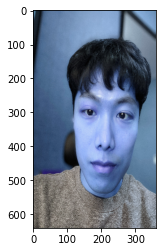

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# 본인의 사진(image.jpg)이 저장되어 있는 경로 저장
my_image_path = os.getenv('HOME')+'/workplace/aiffel/camera_sticker/images/image.jpg'  
img_bgr = cv2.imread(my_image_path)          # OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (360, 640))    # 360x6400의 크기로 Resize
img_show = img_bgr.copy()                    # 출력용 이미지 별도 보관
plt.imshow(img_bgr)                          # figure에 저장된 이미지를 그린다.
plt.show()                                   # figure를 보여준다.

\* os 모듈은 **운영체제의 환경 변수** 값을 읽어올 수 있도록 파이썬에서 자체적으로 지원해주는 모듈입니다. 환경 변수는 일반적으로 운영 체제에서 직접 설정해 주는 변수들인데요. 이를 쉽게 가져오기 위한 용도로 사용됩니다.

\* **cv2.imread()** 메서드는 파일명만 parameter로 받을시 해당 이미지 파일을 color로 읽습니다. 그런데 파일명 뒤에 parameter를 넣을 수 있는데요. IMREAD_COLOR, IMREAD_GRAYSCALE, IMREAD_UNCHANGED 이렇게 총 세가지를 받을 수 있습니다. 각각 생상, 흑백, alpha channel 포함이라는 의미이고 1, 0, -1로 대체할 수 있습니다.
  
그런데 짜잔! 왠 ~~보거스 한마리~~가 있네요.

얼굴이 시퍼래진 이유는 아까 위에서 설명했던 **빨강색**과 **파랑색**의 순서가 다른 OpenCV의 특징 때문입니다.
  
  



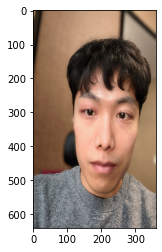

In [14]:
# img_bgr을 BGR 에서 RGB로 convert 해준다.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

이렇게 OpenCV에서 제공하는 cvtColor메서드를 사용해서 색을 바꿔주니 정상적으로 사진이 출력되는 것을 확인할 수 있습니다.  
  
  
  
## 2. face detection

사진이 준비되었으니 이제 사진 속에 있는 얼굴을 찾아내야 하겠죠. 저는 아까 설치한 dlib의 HOG feature를 사용해보겠습니다.
  
구현에 앞서 얼굴인식의 작동방식을 간단하게 살펴보겠습니다.

1) **흑백사진으로 변화** : 얼굴의 형태를 파악하는데 색상은 필요하지 않기때문에 색상을 제거합니다.  
  
2) **gradients 계산** : gradients는 주변 픽셀들의 명암값을 바탕으로 **이미지가 어두워지는 방향**을 나타내는 값입니다. gradients를 사용하는 이유는 같은 인물일 지라도 밝은 곳에서 찍은 사진과 어두운 곳에서 찍은 사진의 속의 얼굴의 밝기는 다를 것이고 기계는 이를 동일한 대상이라고 판단할 수 없기 때문입니다. 하지만 gradients는 절대값이 아닌 **상대값**이기 때문에 **빛의 방향**만 고려하면 되는 장점이 있습니다. 장점이 명확하지만 너무 자세하게 분석을 하면 동일인도 다르게 판별을 할 수 있기 때문에 일반적으로 16 x 16 픽셀 단위로 분해하여 계산합니다.  
  
3) **위치교정**(*posing*)과 **투영**(*projection*) : 사진에서 얼굴은 분리했지만 사람은 2D가 아니기 때문에 다른 각도에서 찍은 사진도 존재하겠죠. 그리고 기계는 이를 너무나 당연스럽게 다른 인물이라고 판단합니다. 이를 해결하기 위해 **face landmark estimation**이라는 방식을 사용할 건데요. 글자 그대로 얼굴에 68개의 랜드마크를 지정하고 그중 눈과 입이 가운데를 향하도록 사진을 회전(*rotate*)시키고 크기를 조절(*scale*)하고 비틉(*shear*)니다. 이러한 방법들을 **이미지변환방법**(*affine transformation*)이라고 합니다.
  
4) **얼굴 인코딩** : 이제 얼굴을 구별하는 단계인데요. 이 곳에서 **딥 컨볼루션 신경망**(*Deep Convolutional Neural Network*)을 이용한 머신러닝이 사용됩니다. 각 인물에 대한 **128개의 측정값**(*embedding*)을 컴퓨터가 스스로 학습을 통해 찾는 단계입니다.
  
5) **사람 이름 찾기** : 이번 단계에서는 추출한 측정값들이 어떤 인물인지 찾는 건데요. SVM classifier와 같은 분류기를 사용해 해당 값이 어떤 사람인지 학습시키면 얼굴인식 알고리즘이 완성됩니다.
  
이제 간단하게 구현을 해보겠습니다.

In [15]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # 이미지파일, 이미지 피라미드 갯수

detector_hog 메서드의 두번째 인자 **이미지 피라미드**(*image pyramids*)에 대해서 간략하게 알아보겠습니다.  
  
이미지 피라미드에는 두가지 종류가 있는데요. 하나는 **Gaussian Pyramids**이고 다른 하나는 **Laplacian Pyramids**입니다. Gaussian Pyramids는 원본 이미지(높은 해상도)에서 row와 column을 제거해서 **사이즈를 줄여나가면서 쌓는 방식**입니다. Laplacian Pyramids는 Gaussian Pyramids로 생성된 이미지 피라미드에 pyrDown()메서드와 pyrUp()메서드를 사용해서 하면 **반올림에 의한 픽셀의 차이로 테두리**가 생기는데 이를 저장해 높은 이미지 피라미드입니다.  
  
이미지 피라미드는 이미지 검출이나 결합 등 다양한 분야에서 사용됩니다.


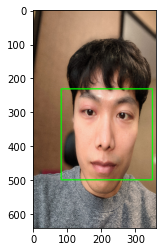

In [16]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 해당 이미지파일 내 사각형의 크기와 위치, 색상, 선의 굵기, 선의 타입을 설정
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴 인식기가 제 얼굴을 정확하게 검출해내는 것을 확인할 수 있습니다.
  
## 3. Face Landmark
  
이제 검출된 얼굴에서 눈,코,입 등 특정 포인트들을 찾아낼 차례인데요. 이러한 기술을 **face landmark localization**이라고 합니다. 그럼 이제 face landmark localization의 알고로즘에 대해서 잠시 살펴보겠습니다.

한 객체에서 특정 포인트를 찾아내는 기술을 **object keypoint estimation**이라고 하는데요. keypoint를 찾는 방식에는 크게 **top-down**방식과 **bottom-up**방식이 있습니다.  
top-down 방식은 **bounding box를 먼저 찾고 그 안에서 keypoint들을 찾아내는 방식**이고, bottom-up 방식은 이미지 내에서 **keypoint들을 먼저 찾은 후에 찾아낸 point들을 이용해서 bounding box를 생성**하는 방식입니다.

이제 구현을 해볼건데요. 저는 dlib에서 제공해주는 모델을 사용해보겠습니다.

\$ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2  
\$ mv shape_predictor_68_face_landmarks.dat.bz2 ~/workplace/aiffel/camera_sticker/models  
\$ cd ~/workplace/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2  

68


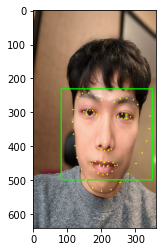

In [17]:
import os
model_path = os.getenv('HOME')+'/workplace/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
list_landmarks = []
for dlib_rect in dlib_rects:
    # 사진과 bounding box를 변수로 받는 predictor메서드
    points = landmark_predictor(img_rgb, dlib_rect)
    # 추출한 포인트들을 xy좌표를 맵핑하여 리스트로 변환
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        # OpenCV에서 제공하는 원을 그리는 메서드. 이미지 파일, 원의 모양, 크기, 색상, 테두리?를 설정
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴 테두리, 눈썹, 눈, 코, 입 등 노랑색 점으로 landmark가 찍히는 것을 확인할 수 있습니다.

## 4. 스티커 구현하기

이제 왕관을 씌워줄 차례입니다. 저는 코를 기준으로해서 일정 높이 위에 왕관을 씌워줄 예정입니다. 일단 계산을 위해서 코와 높낮이 등의 좌표를 구해보겠습니다.

In [18]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(211, 388)
(x,y) : (211,254)
(w,h) : (268,268)


왕관을 씌울 좌표를 구했습니다. 이제 왕관사진의 크기를 맞추고 좌표값을 지정해보겠습니다.

In [19]:
import os
sticker_path = os.getenv('HOME')+'/workplace/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # 크기변환
print (img_sticker.shape)
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(268, 268, 3)
(x,y) : (77,-14)


그런데 이상한 점이 있네요. y 좌표가 음수가 나왔습니다.  
이 말은 왕관 이미지가 원본사진의 밖으로 삐져나왔다는 말인데요.
이 문제를 해결하려면 빠져나온 부분을 잘라줘야 합니다(*crop*).

(254, 268, 3)
(x,y) : (77,0)


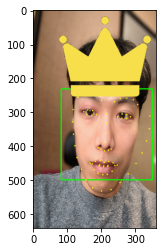

In [20]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 스티커가 0인 부분은 area를 사용하고 나머지는 스티커를 사용
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8) 
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이제 왕관이 잘 써있는 것을 테스트 해봤으니 bounding box와 landmark만 제거하면 왕관 씌우기는 완성입니다.

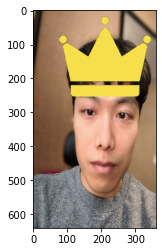

In [21]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

잘 작동하네요. 왕관씌우기 어플 예제는 이것으로 마무리하고 고양이 수염 스티커를 붙이는 어플을 만들어 보겠습니다.

## 5. 고양이 수염 붙이기 프로젝트



사진준비


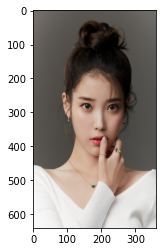

face detection


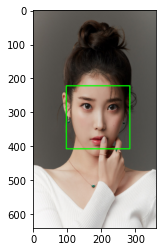

face landmark


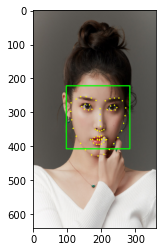

테스트


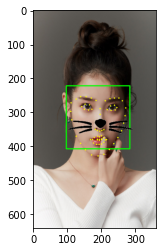

최종


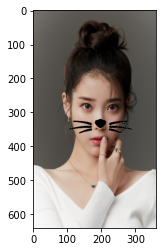

In [86]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. 사진준비
# 본인의 사진(image.jpg)이 저장되어 있는 경로 저장
my_image_path = os.getenv('HOME')+'/workplace/aiffel/camera_sticker/images/image.jpg'  
img_bgr = cv2.imread(my_image_path)          # OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (360, 640))    # 360x6400의 크기로 Resize
img_show = img_bgr.copy()                    # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
print("사진준비")
plt.show()

# 2. face detection
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # 이미지파일, 이미지 피라미드 갯수

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 해당 이미지파일 내 사각형의 크기와 위치, 색상, 선의 굵기, 선의 타입을 설정
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
print("face detection")
plt.show()

# 3. face landmark
model_path = os.getenv('HOME')+'/workplace/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
list_landmarks = []
for dlib_rect in dlib_rects:
    # 사진과 bounding box를 변수로 받는 predictor메서드
    points = landmark_predictor(img_rgb, dlib_rect)
    # 추출한 포인트들을 xy좌표를 맵핑하여 리스트로 변환
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        # OpenCV에서 제공하는 원을 그리는 메서드. 이미지 파일, 원의 모양, 크기, 색상, 테두리?를 설정
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
print("face landmark")
plt.show()

# 4. 스티커 구현
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1] # - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.height()
    
sticker_path = os.getenv('HOME')+'/workplace/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # 크기변환
# refined_x = x - w // 2  # left
# refined_y = y - h // 2  # top
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0

sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0],
                        refined_x:refined_x + img_sticker.shape[1]]
# 스티커가 255인 부분은 area를 사용하고 나머지는 스티커를 사용
img_show[refined_y:refined_y + img_sticker.shape[0],
         refined_x:refined_x + img_sticker.shape[1]] = \
         np.where(img_sticker == 255,sticker_area,img_sticker).astype(np.uint8) 
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
print("테스트")
plt.show()

sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0],
                       refined_x:refined_x + img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0],
        refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
print("최종")
plt.show()



## 회고
이상없이 잘되는 것을 확인할 수 있습니다. 현재 저는 정면사진만을 가지고 스티커를 부착해봤는데요.  
여러가지 사진들로 테스트를 진행해보면서 몇가지 기능적인 문제들을 발견했습니다.

1. 인물이 방향을 틀어도 고양이 수염의 방향은 변하지 않아 어색한 느낌이 들었다.
2. 멀리서 촬영하면 얼굴이 인식이 안되는지 인식이 안되었다.
3. 옆으로 누워서 촬영시 눈이 없는 등 얼굴형이 많이 달라서 그런지 몰라도 인식이 되지 않았다.

촬영을 해본 결과 속도면에서는 많이 느리지는 않았으나 좌표설정에 어려움이 있어 여러사람에 맞는 적절한 좌표를 찾는 코딩을 하는것이 중요한 것 같았습니다.